# K-Nearest Neighbors Algorithm

In [22]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
# Get the current directory
current_dir = os.getcwd()

# Get the path to the parent directory
parent_dir = os.path.dirname(current_dir)

# Specify the filename
filename = 'final.sqlite'

# Construct the path to the file in the parent directory
file_path = os.path.join(parent_dir, filename)

# Check if the file exists
if os.path.isfile(file_path):
    conn = sqlite3.connect(file_path)
    final = pd.read_sql_query('select * from reviews', conn)
    conn.close()
else:
    print('Please run Text Preprocessing code file')

In [3]:
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


In [4]:
# Sorting data based on time for time based splitting
final = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# Now we will perform time based slicing
x_train_raw = final['CleanedText'][0:50000]
y_train = final['Score'][0:50000]
x_cv_raw = final['CleanedText'][50000:70000]
y_cv = final['Score'][50000:70000]
x_test_raw = final['CleanedText'][70000:87773]
y_test = final['Score'][70000:87773]

In [5]:
# Some common initializations used in whole of the assignment
neighbors = np.arange(1,30,1)
mask = neighbors%2 != 0
neighbors = neighbors[mask]

Now we will be training BOW, Tfidf and W2V features using both brute force and kd-tree implementaion of KNN

## Applying KNN-brute force using BOW

### Training

In [6]:
# count_vect = CountVectorizer()
# count_vect.fit(x_train_raw.values)
# filename = 'brute_bow'
# pickle.dump(count_vect, open(filename, 'wb'))

In [14]:
count_vect = pickle.load(open('brute_bow', 'rb'))
x_train = count_vect.transform(x_train_raw.values)
x_cv = count_vect.transform(x_cv_raw.values)
train_auc = []
cv_auc = []
# performing simple cross-validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_train_pred = []
    y_cv_pred = []
    for i in range(0, x_train.shape[0], 1000): # using loop to avoid memory error
        y_train_pred.extend(knn.predict_proba(x_train[i:i+1000,:])[:,1])
    for i in range(0, x_cv.shape[0], 1000):
        y_cv_pred.extend(knn.predict_proba(x_cv[i:i+1000,:])[:,1])
    train_auc.append(roc_auc_score(y_train, y_train_pred)) # appending AUC
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

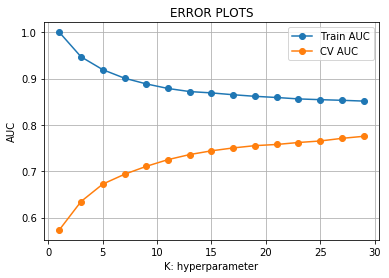

In [16]:
# plotting AUC for different values of k for both train and cv data
plt.plot(neighbors, train_auc, label='Train AUC', marker='o')
plt.plot(neighbors, cv_auc, label='CV AUC', marker='o')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.grid()
plt.show()

In [9]:
# optimal_k = 9
# brute_bow_k = optimal_k
# knn_for_optimal_k = KNeighborsClassifier(n_neighbors=optimal_k)
# knn_for_optimal_k.fit(x_train, y_train)
# filename = 'brute_bow_knn'
# pickle.dump(knn_for_optimal_k, open(filename, 'wb'))

### Testing

In [7]:
count_vect = pickle.load(open('brute_bow', 'rb'))
knn_for_optimal_k = pickle.load(open('brute_bow_knn', 'rb'))
x_train = count_vect.transform(x_train_raw.values)
x_test = count_vect.transform(x_test_raw)
y_test_pred = []
y_train_pred_proba = [] # we will be comparing model results on train and test data
y_test_pred_proba = []
for i in range(0, x_train.shape[0], 1000):
    y_train_pred_proba.extend(knn_for_optimal_k.predict_proba(x_train[i:i+1000])[:,1]) # to build ROC curve
for i in range(0, x_test.shape[0], 1000):
    y_test_pred.extend(knn_for_optimal_k.predict(x_test[i:i+1000])) # to find accuracy
    y_test_pred_proba.extend(knn_for_optimal_k.predict_proba(x_test[i:i+1000])[:,1]) # to build ROC curve

In [12]:
acc = accuracy_score(y_test, y_test_pred) * 100
print('the accuracy for k = {} using simple crossvalidation for BOW is {}'.format(optimal_k, acc))

the accuracy for k = 9 using simple crossvalidation for BOW is 83.87441624936702


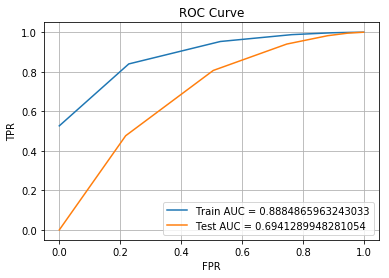

In [21]:
# plotting ROC
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_pred_proba)
brute_bow_train_auc = auc(train_fpr, train_tpr)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
brute_bow_auc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label = 'Train AUC = ' + str(brute_bow_train_auc))
plt.plot(test_fpr, test_tpr, label = 'Test AUC = ' + str(brute_bow_auc))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid()
plt.show()

Confusion Matrix : 


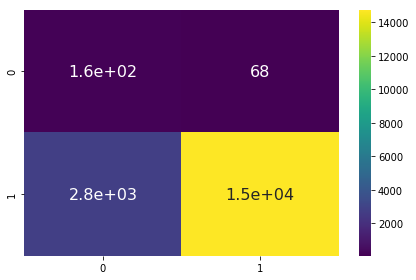

In [29]:
print('Confusion Matrix : ')
matrix = confusion_matrix(y_test, y_test_pred).T
sns.heatmap(matrix, annot=True, annot_kws = {'size' : 16}, cmap='viridis')
plt.tight_layout()